In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bank-customer-segmentation/bank_transactions.csv


In [3]:
import numpy as np
import pandas as pd
import seaborn as sb
import scipy.cluster.hierarchy as shc
import re

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering
from sklearn.cluster import DBSCAN

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d


In [4]:
try:
    from kneed import KneeLocator 
except:
    !pip install kneed
    from kneed import KneeLocator
try:
    from yellowbrick.cluster import KElbowVisualizer
except:
    !pip install -U yellowbrick
    from yellowbrick.cluster import KElbowVisualizer 

In [5]:
try:
    import plotly.express as px
    import plotly.graph_objects as go
except:
    !pip install plotly
    import plotly.express as px
    import plotly.graph_objects as go

In [6]:
data = pd.read_csv("/kaggle/input/bank-customer-segmentation/bank_transactions.csv")
data.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   CustomerID               1048567 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1047467 non-null  object 
 4   CustLocation             1048416 non-null  object 
 5   CustAccountBalance       1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionTime          1048567 non-null  int64  
 8   TransactionAmount (INR)  1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB


In [8]:
data.shape

(1048567, 9)

In [9]:
def check(df):
    l=[]
    columns=df.columns
    for col in columns:
        dtypes=df[col].dtypes
        nunique=df[col].nunique()
        sum_null=df[col].isnull().sum()
        l.append([col,dtypes,nunique,sum_null])
    df_check=pd.DataFrame(l)
    df_check.columns=['column','dtypes','nunique','sum_null']
    return df_check
check(data)

,column,dtypes,nunique,sum_null
0,TransactionID,object,1048567,0
1,CustomerID,object,884265,0
2,CustomerDOB,object,17254,3397
3,CustGender,object,3,1100
4,CustLocation,object,9355,151
5,CustAccountBalance,float64,161328,2369
6,TransactionDate,object,55,0
7,TransactionTime,int64,81918,0
8,TransactionAmount (INR),float64,93024,0


In [10]:
data.duplicated().sum()

0

Text(0.5, 1.0, 'Frequency')

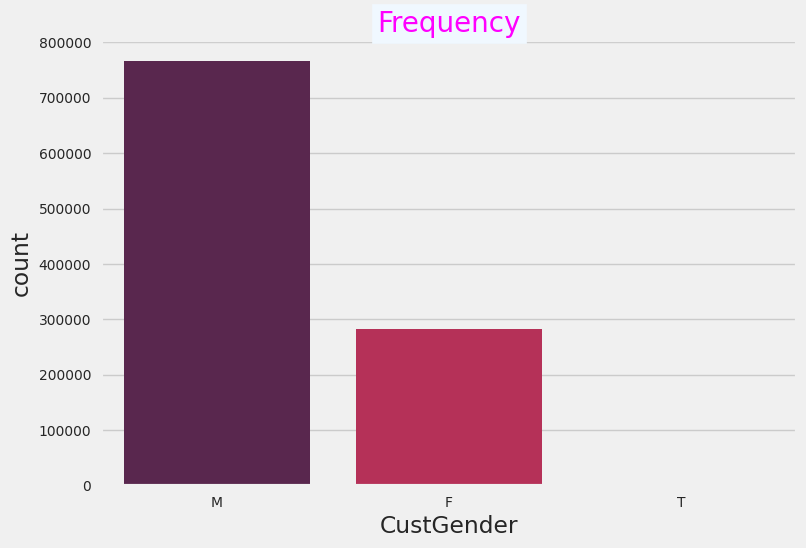

In [11]:
plt.style.use("fivethirtyeight")
chart=sb.countplot(x='CustGender',data=data,palette='rocket',order=data['CustGender'].value_counts().index)
plt.title("Frequency",fontsize='20',backgroundcolor='AliceBlue',color='magenta')

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   CustomerID               1048567 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1047467 non-null  object 
 4   CustLocation             1048416 non-null  object 
 5   CustAccountBalance       1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionTime          1048567 non-null  int64  
 8   TransactionAmount (INR)  1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB


In [13]:
data.isnull().sum()

TransactionID                 0
CustomerID                    0
CustomerDOB                3397
CustGender                 1100
CustLocation                151
CustAccountBalance         2369
TransactionDate               0
TransactionTime               0
TransactionAmount (INR)       0
dtype: int64

In [14]:
data.dropna(subset=['CustLocation','CustomerDOB','CustAccountBalance'],inplace=True)
data.shape

(1042651, 9)

In [15]:
data.fillna({
    "CustGender":"M"
}, inplace = True)

In [16]:
data["CustomerDOB"]=pd.to_datetime(data["CustomerDOB"])
data["TransactionDate"]=pd.to_datetime(data["TransactionDate"])

data["CustomerAge"] = data["TransactionDate"].dt.year
-data["CustomerDOB"].dt.year

/tmp/ipykernel_32/4068716522.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data["CustomerDOB"]=pd.to_datetime(data["CustomerDOB"])
/tmp/ipykernel_32/4068716522.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data["TransactionDate"]=pd.to_datetime(data["TransactionDate"])


0         -1994
1         -2057
2         -1996
3         -1973
4         -1988
           ... 
1048562   -1990
1048563   -1992
1048564   -1989
1048565   -1978
1048566   -1984
Name: CustomerDOB, Length: 1042651, dtype: int32

In [17]:
data['TransactionDate1']=data['TransactionDate']
data['TransactionDate2']=data['TransactionDate']

In [18]:
RMF_data = data.groupby("CustomerID").agg({
    "TransactionID" : "count",
    "CustGender" : "first",
    "CustLocation" : "first",
    "CustAccountBalance" : "mean",
    "TransactionAmount (INR)" : "mean",
    "CustomerAge" : "max",
    "TransactionDate2" : "max",
    "TransactionDate1" : "min",
    "TransactionDate" : "median",
})
RMF_data = RMF_data.reset_index()
RMF_data.head()

,CustomerID,TransactionID,CustGender,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerAge,TransactionDate2,TransactionDate1,TransactionDate
0,C1010011,2,F,NOIDA,76340.635,2553.0,2016,2016-09-26,2016-09-08,2016-09-17
1,C1010012,1,M,MUMBAI,24204.490,1499.0,2016,2016-08-14,2016-08-14,2016-08-14
2,C1010014,2,F,MUMBAI,100112.950,727.5,2016,2016-07-08,2016-01-08,2016-04-08
3,C1010018,1,F,CHAMPARAN,496.180,30.0,2016,2016-09-15,2016-09-15,2016-09-15
4,C1010024,1,M,KOLKATA,87058.650,5000.0,2016,2016-08-18,2016-08-18,2016-08-18


In [19]:
RMF_data.drop(columns=['CustomerID'],inplace=True)

In [20]:
RMF_data['Recency']=RMF_data['TransactionDate2']-RMF_data['TransactionDate1']

In [21]:
RMF_data['Recency']=RMF_data['Recency'].astype(str)
RMF_data.head()

,TransactionID,CustGender,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerAge,TransactionDate2,TransactionDate1,TransactionDate,Recency
0,2,F,NOIDA,76340.635,2553.0,2016,2016-09-26,2016-09-08,2016-09-17,18 days
1,1,M,MUMBAI,24204.490,1499.0,2016,2016-08-14,2016-08-14,2016-08-14,0 days
2,2,F,MUMBAI,100112.950,727.5,2016,2016-07-08,2016-01-08,2016-04-08,182 days
3,1,F,CHAMPARAN,496.180,30.0,2016,2016-09-15,2016-09-15,2016-09-15,0 days
4,1,M,KOLKATA,87058.650,5000.0,2016,2016-08-18,2016-08-18,2016-08-18,0 days


In [22]:
RMF_data['Recency']=RMF_data['Recency'].apply(lambda x:re.search('\d+',x).group())
RMF_data['Recency']=RMF_data['Recency'].astype(int)

In [23]:
def rep_0(i):
    if i==0:
        return 1
    else:
        return 1
RMF_data['Recency']=RMF_data['Recency'].apply(rep_0)

In [24]:
RMF_data.drop(columns=['TransactionDate1',"TransactionDate2"],inplace=True)
RMF_data.head(3)

,TransactionID,CustGender,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerAge,TransactionDate,Recency
0,2,F,NOIDA,76340.635,2553.0,2016,2016-09-17,1
1,1,M,MUMBAI,24204.490,1499.0,2016,2016-08-14,1
2,2,F,MUMBAI,100112.950,727.5,2016,2016-04-08,1


In [25]:
RMF_data.rename(columns={'TransactionID':"Frequency"},inplace=True)

In [26]:
lower_list=[]
upper_list=[]
num_list=[]
perc_list=[]
cols=['Frequency','CustAccountBalance','TransactionAmount (INR)','CustomerAge','Recency']
for i in cols:
    Q1 = RMF_data[i].quantile(0.25)
    Q3 = RMF_data[i].quantile(0.75)
    IQR = Q3 -Q1
    lower = Q1 -1.5 * IQR
    upper = Q3 +1.5 * IQR
    num=RMF_data[(RMF_data[i]<lower) | (RMF_data[i]>upper)].shape[0]
    perc = (num/RMF_data.shape[0])*100
    lower_list.append(lower)
    upper_list.append(upper)
    num_list.append(num)
    perc_list.append(round(perc,2))
dic={'lower' : lower_list, 'upper':upper_list, 'outliers' : num_list, 'Perc%' : perc_list}
outliers_df=pd.DataFrame(dic,index=['Frequency','CustAccountBalance','TransactionAmount (INR)','CustomerAge','Recency'])
outliers_df

,lower,upper,outliers,Perc%
Frequency,1.0000,1.0000,142200,16.16
CustAccountBalance,-78311.0400,145397.4400,116609,13.25
TransactionAmount (INR),-1385.4825,2817.1375,91878,10.44
CustomerAge,2016.0000,2016.0000,0,0.00
Recency,1.0000,1.0000,0,0.00


EDA

In [27]:
RMF_data.describe()

,Frequency,CustAccountBalance,TransactionAmount (INR),CustomerAge,TransactionDate,Recency
count,880115.000000,8.801150e+05,8.801150e+05,880115.0,880115,880115.0
mean,1.184676,1.146274e+05,1.567101e+03,2016.0,2016-07-26 00:34:18.358282240,1.0
min,1.000000,0.000000e+00,0.000000e+00,2016.0,2016-01-08 00:00:00,1.0
25%,1.000000,5.579640e+03,1.905000e+02,2016.0,2016-06-09 00:00:00,1.0
50%,1.000000,1.864142e+04,5.000000e+02,2016.0,2016-08-19 00:00:00,1.0
75%,1.000000,6.150676e+04,1.241155e+03,2016.0,2016-09-09 00:00:00,1.0
max,6.000000,1.150355e+08,1.560035e+06,2016.0,2016-12-09 00:00:00,1.0
std,0.449134,8.007375e+05,6.432428e+03,0.0,NaN,0.0


In [28]:
RMF_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 880115 entries, 0 to 880114
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   Frequency                880115 non-null  int64         
 1   CustGender               880115 non-null  object        
 2   CustLocation             880115 non-null  object        
 3   CustAccountBalance       880115 non-null  float64       
 4   TransactionAmount (INR)  880115 non-null  float64       
 5   CustomerAge              880115 non-null  int32         
 6   TransactionDate          880115 non-null  datetime64[ns]
 7   Recency                  880115 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(2), object(2)
memory usage: 50.4+ MB


In [29]:
from sklearn.preprocessing import LabelEncoder
lr=LabelEncoder()
RMF_data['CustGender']=lr.fit_transform(RMF_data['CustGender'])

In [30]:
from sklearn.preprocessing import LabelEncoder
lr=LabelEncoder()
RMF_data['CustLocation']=lr.fit_transform(RMF_data['CustLocation'])

<Axes: >

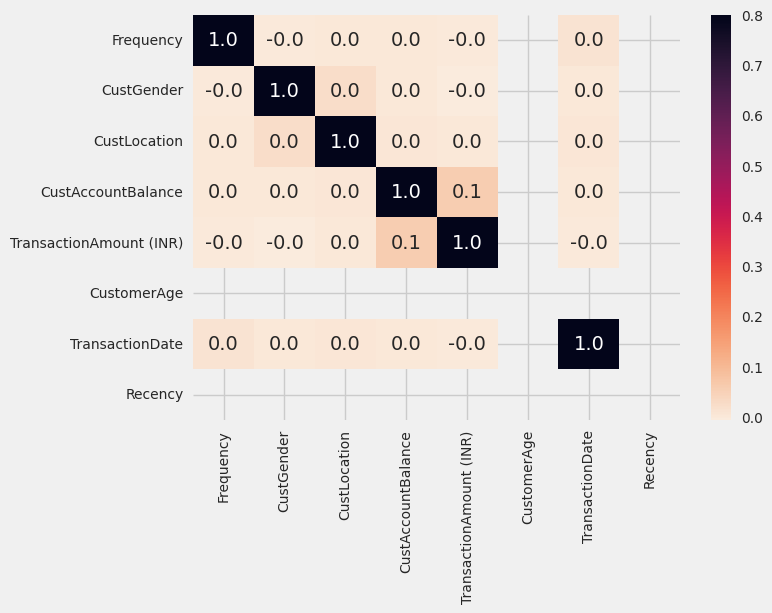

In [31]:
plt.figure(figsize=(7,5))
correlation=RMF_data.corr()
sb.heatmap(correlation,vmin=None,vmax=0.8,cmap='rocket_r',annot=True,fmt='.1f',linecolor='white',cbar=True)

In [32]:
RMF_data.reset_index(drop=True, inplace=True)
RMF_data.head()

,Frequency,CustGender,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerAge,TransactionDate,Recency
0,2,0,5632,76340.635,2553.0,2016,2016-09-17,1
1,1,1,5040,24204.490,1499.0,2016,2016-08-14,1
2,2,0,5040,100112.950,727.5,2016,2016-04-08,1
3,1,0,1452,496.180,30.0,2016,2016-09-15,1
4,1,1,4087,87058.650,5000.0,2016,2016-08-18,1


In [33]:
minmax = MinMaxScaler()
standard_scaler = StandardScaler()
RMF_scaled =RMF_data.copy()
RMF_scaled[["Frequency", "CustGender","Recency","CustLocation"]] = minmax.fit_transform(RMF_data[["Frequency", "CustGender","Recency","CustLocation"]])
RMF_scaled[["CustAccountBalance", "TransactionAmount (INR)","CustomerAge"]] = standard_scaler.fit_transform(RMF_data[["CustAccountBalance", "TransactionAmount (INR)","CustomerAge"]])

In [34]:
RMF_scaled.head()

,Frequency,CustGender,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerAge,TransactionDate,Recency
0,0.2,0.0,0.629414,-0.047814,0.153270,0.0,2016-09-17,0.0
1,0.0,0.5,0.563254,-0.112925,-0.010587,0.0,2016-08-14,0.0
2,0.2,0.0,0.563254,-0.018126,-0.130526,0.0,2016-04-08,0.0
3,0.0,0.0,0.162271,-0.142533,-0.238961,0.0,2016-09-15,0.0
4,0.0,0.5,0.456750,-0.034429,0.533687,0.0,2016-08-18,0.0


In [35]:
RMF_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 880115 entries, 0 to 880114
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   Frequency                880115 non-null  float64       
 1   CustGender               880115 non-null  float64       
 2   CustLocation             880115 non-null  float64       
 3   CustAccountBalance       880115 non-null  float64       
 4   TransactionAmount (INR)  880115 non-null  float64       
 5   CustomerAge              880115 non-null  float64       
 6   TransactionDate          880115 non-null  datetime64[ns]
 7   Recency                  880115 non-null  float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 53.7 MB


In [36]:
RMF_scaled.drop(columns=['TransactionDate'],inplace=True)

In [37]:
RMF_scaled.head()

,Frequency,CustGender,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerAge,Recency
0,0.2,0.0,0.629414,-0.047814,0.153270,0.0,0.0
1,0.0,0.5,0.563254,-0.112925,-0.010587,0.0,0.0
2,0.2,0.0,0.563254,-0.018126,-0.130526,0.0,0.0
3,0.0,0.0,0.162271,-0.142533,-0.238961,0.0,0.0
4,0.0,0.5,0.456750,-0.034429,0.533687,0.0,0.0


In [38]:
RMF_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 880115 entries, 0 to 880114
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Frequency                880115 non-null  float64
 1   CustGender               880115 non-null  float64
 2   CustLocation             880115 non-null  float64
 3   CustAccountBalance       880115 non-null  float64
 4   TransactionAmount (INR)  880115 non-null  float64
 5   CustomerAge              880115 non-null  float64
 6   Recency                  880115 non-null  float64
dtypes: float64(7)
memory usage: 47.0 MB


In [59]:
RMF_scaled=RMF_scaled.sample(n=7500,random_state=69).reset_index(drop=True)
RMF_scaled.head()

,Frequency,CustGender,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerAge,Recency
0,0.0,0.5,0.456750,-0.009927,-0.041524,0.0,0.0
1,0.0,0.5,0.718373,0.771925,-0.181440,0.0,0.0
2,0.0,0.0,0.221055,0.019369,0.510367,0.0,0.0
3,0.0,0.5,0.619133,1.226639,-0.226607,0.0,0.0
4,0.0,0.5,0.382655,-0.143135,-0.198852,0.0,0.0


PCA

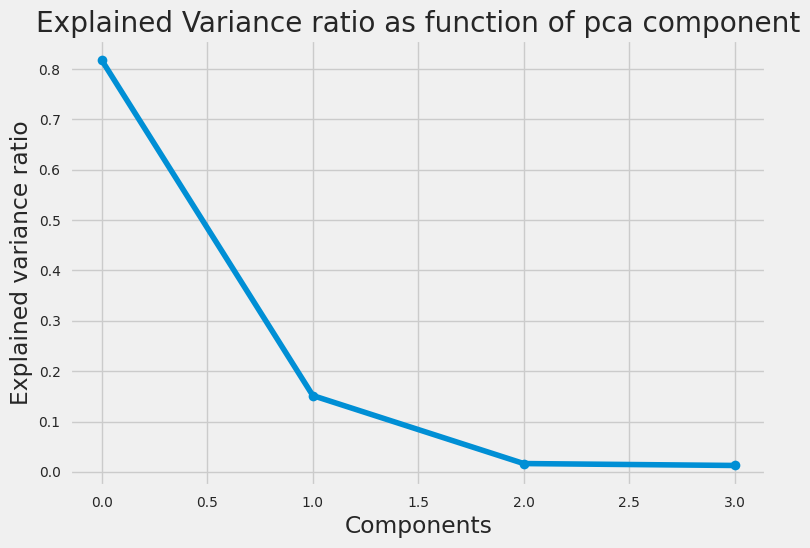

In [60]:
trail_pca=PCA(n_components=4)
trail_pca.fit(RMF_scaled)
test=trail_pca.transform(RMF_scaled)
plt.plot(list(trail_pca.explained_variance_ratio_),'-o')
plt.title('Explained Variance ratio as function of pca component')
plt.ylabel('Explained variance ratio')
plt.xlabel('Components')
plt.show()

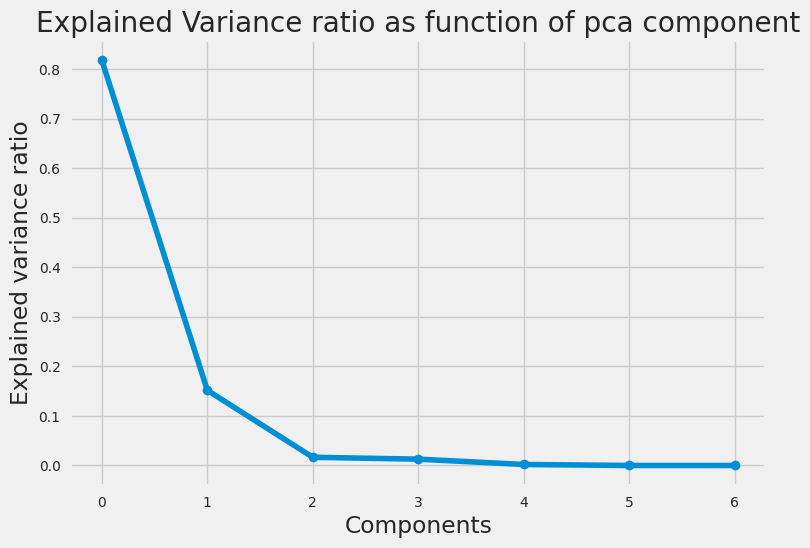

In [61]:
trail_pca=PCA(n_components=7)
trail_pca.fit(RMF_scaled)
test=trail_pca.transform(RMF_scaled)
plt.plot(list(trail_pca.explained_variance_ratio_),'-o')
plt.title('Explained Variance ratio as function of pca component')
plt.ylabel('Explained variance ratio')
plt.xlabel('Components')
plt.show()

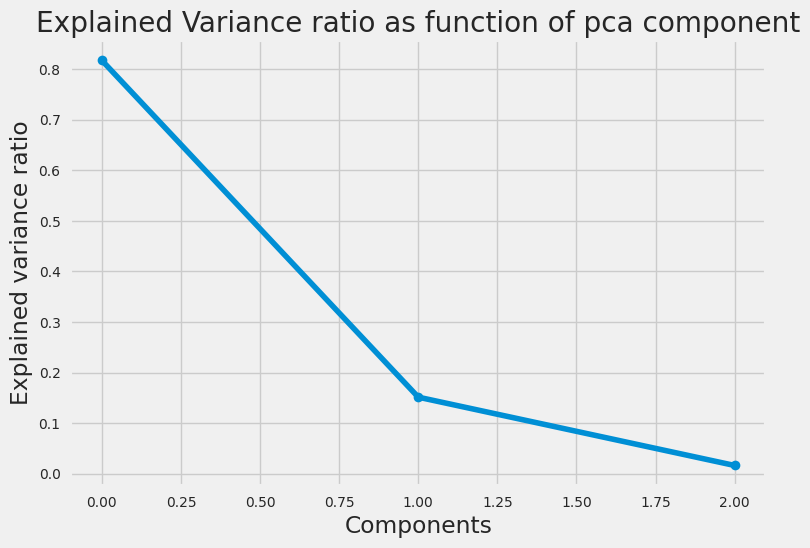

In [62]:
trail_pca=PCA(n_components=3)
trail_pca.fit(RMF_scaled)
test=trail_pca.transform(RMF_scaled)
plt.plot(list(trail_pca.explained_variance_ratio_),'-o')
plt.title('Explained Variance ratio as function of pca component')
plt.ylabel('Explained variance ratio')
plt.xlabel('Components')
plt.show()

In [63]:
RMF_pca=PCA(n_components=3)
reduced_features=RMF_pca.fit_transform(RMF_scaled)
x_principal=pd.DataFrame(reduced_features)
x_principal.columns=['p1','p2','p3']

In [64]:
x_principal

,p1,p2,p3
0,-0.025554,-0.034340,0.026539
1,0.755243,-0.183883,0.285159
2,0.009689,0.521163,-0.244898
3,1.209115,-0.234440,0.184925
4,-0.160843,-0.189984,-0.047210
...,...,...,...
7495,-0.096150,-0.204474,0.173587
7496,-0.142385,-0.192314,0.510319
7497,-0.056015,-0.076673,-0.157408
7498,0.456536,-0.218214,-0.101929


KMeans

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

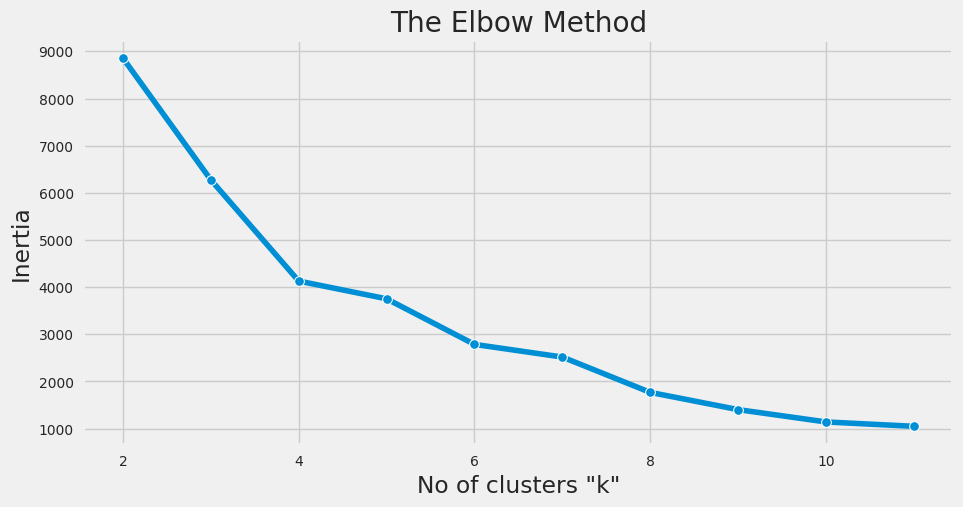

In [65]:
# Elbow-curve
kmeans_set = {"init":"random", "max_iter":300, "random_state":42}
ssd = []
range_n_clusters = range(2,12)
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters,**kmeans_set)
    kmeans.fit(RMF_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
ig, ax = plt.subplots(figsize=(10,5))
sb.lineplot(y=ssd, x=range_n_clusters, marker='o',ax=ax )
plt.title('The Elbow Method')
plt.xlabel('No of clusters "k"')
plt.ylabel('Inertia')
plt.show();

In [66]:
WCSS =[]
silh_scores_kmeans =  []
db_scores_kmeans = []
for n_cluster in range(2,11):
    model_kmeans = KMeans(n_clusters = n_cluster)
    model_kmeans.fit(reduced_features)
    WCSS.append(model_kmeans.inertia_)
    silh_scores_kmeans.append(silhouette_score(reduced_features,model_kmeans.labels_))
    db_scores_kmeans.append(davies_bouldin_score(reduced_features,model_kmeans.labels_))

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

In [67]:
silh_scores_kmeans

[0.9950431377865712,
 0.9265429542669723,
 0.9290894620774656,
 0.849715190236064,
 0.8322653964569111,
 0.6415311745981931,
 0.43297865144925957,
 0.44031717699732303,
 0.4543781666231047]

In [68]:
db_scores_kmeans

[0.0032974952799494613,
 0.32317105365199783,
 0.4659406149275729,
 0.42889231646485537,
 0.4262866085425003,
 0.47216052103835204,
 0.5423785743928754,
 0.5381291409014585,
 0.5269408143211974]

In [69]:
WCSS

[8422.422573821337,
 5838.036626492069,
 3695.255545456812,
 2719.6547756585032,
 1963.9628435867808,
 1572.3080376156404,
 1235.8211106011274,
 966.5901329540163,
 782.4563382113492]

In [70]:
model_kmeans

KMeans(n_clusters=10)

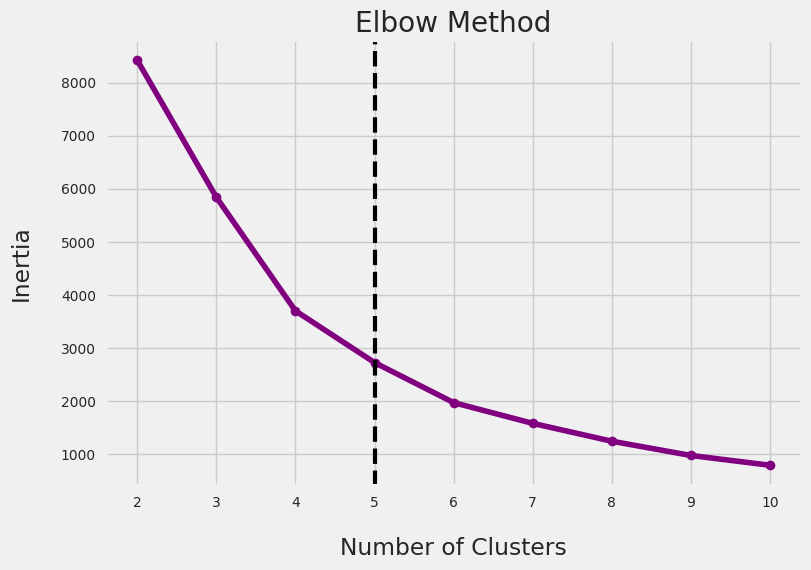

In [71]:
plt.style.use("fivethirtyeight")
k1=KneeLocator(range(2,11),WCSS, curve='convex', direction='decreasing')
plt.plot(range(2,11),WCSS, color='purple', marker='o',label='Elbow method')
plt.xticks(range(2,11))
plt.xlabel("Number of Clusters", labelpad=20)
plt.ylabel("Inertia",labelpad=20)
plt.title("Elbow Method")
plt.axvline(x=k1.elbow, color='black',label='axvline-fullheight',ls='--', linewidth=3)

In [73]:
x_principal=x_principal.sample(n=1000,random_state=69).reset_index(drop=True)
x_principal.shape

(1000, 3)

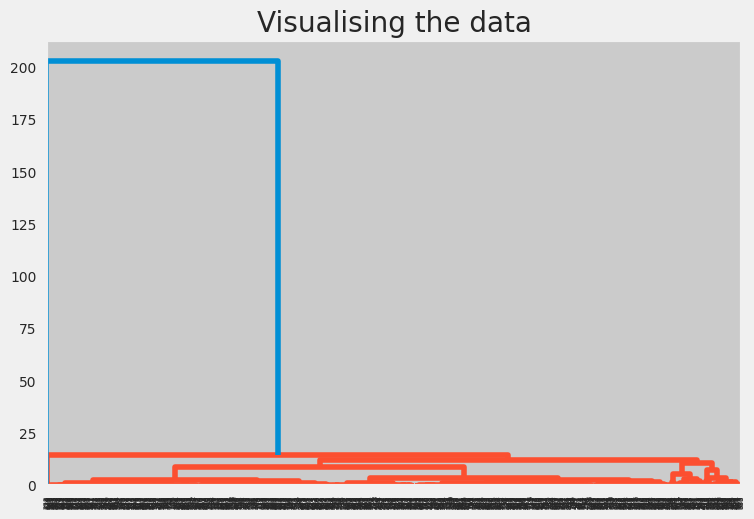

In [74]:
plt.title('Visualising the data')
Dendogram=shc.dendrogram((shc.linkage(x_principal,method='ward')))

In [86]:
silh_scores_agglo = []
db_scores_agglo =[]
for n_cluster in range(2,11):
    model_agglo= AgglomerativeClustering(n_clusters=n_cluster)
    model_agglo.fit(x_principal)
    
    silh_scores_agglo.append(silhouette_score(x_principal, model_agglo.labels_))
    db_scores_agglo.append(davies_bouldin_score(x_principal, model_agglo.labels_))

In [87]:
silh_scores_agglo

[0.995102357277897,
 0.9247079529275936,
 0.6346520364967494,
 0.651680544344985,
 0.4500834660959465,
 0.4571642745365769,
 0.46254580655354305,
 0.46340589775993546,
 0.37353683162660334]

In [88]:
db_scores_agglo

[0.002696397776908996,
 0.07793612290850425,
 0.7260680208159217,
 0.5325553252477012,
 0.5745878712378617,
 0.5335096780605876,
 0.5426238867588262,
 0.5430966821365373,
 0.6238528685065747]

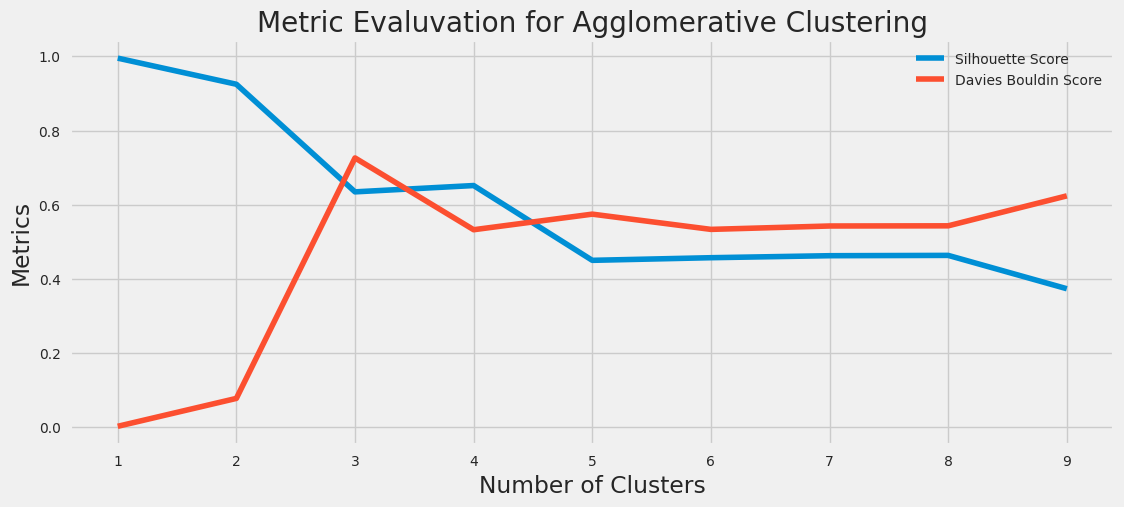

In [93]:
plt.figure(figsize=(12,5))
plt.plot(range(1,10),silh_scores_agglo, label="Silhouette Score")
plt.plot(range(1,10),db_scores_agglo, label="Davies Bouldin Score")
plt.xlabel("Number of Clusters")
plt.ylabel("Metrics")
plt.title("Metric Evaluvation for Agglomerative Clustering")
plt.legend()

In [94]:
db = DBSCAN(eps=10,min_samples=1000).fit(x_principal)
core_samples_mask=np.zeros_like(db.labels_,dtype=bool)
core_samples_mask[db.core_sample_indices_]=True
labels=db.labels_

In [95]:
x_principal['label']= labels
x_principal.head()

,p1,p2,p3,label
0,0.140159,-0.230293,0.132034,-1
1,-0.150553,-0.055060,-0.204646,-1
2,-0.088000,-0.220487,-0.132812,-1
3,-0.158819,-0.212684,0.380953,-1
4,-0.137332,-0.138086,0.095813,-1


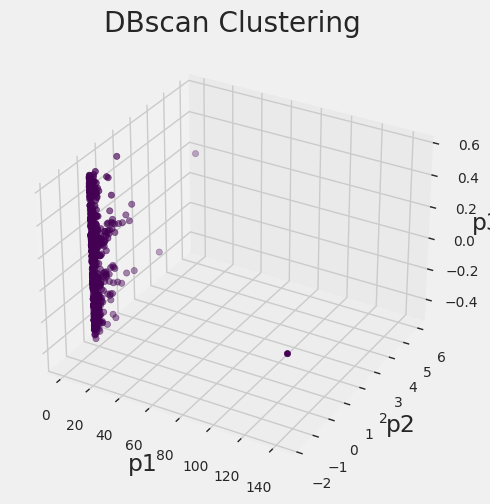

In [98]:
ax = plt.axes(projection='3d')
ax.scatter3D('p1','p2','p3', c='label', data=x_principal, cmap='viridis',linewidth=0.5)
ax.set_xlabel('p1')
ax.set_ylabel('p2')
ax.set_zlabel('p3')
plt.title("DBscan Clustering")
plt.legend()
plt.show()